In [2]:
from dotenv import load_dotenv
import os
from vanna.vannadb import VannaDB_VectorStore
from vanna.google import GoogleGeminiChat
import pandas as pd
import duckdb

In [3]:
load_dotenv(override=True)
vanna_key = os.getenv('vanna_api')
gemini_key = os.getenv('gemini_api')

class MyVanna(VannaDB_VectorStore, GoogleGeminiChat):
    def __init__(self, config=None):
        MY_VANNA_MODEL = 'diabetes'
        VannaDB_VectorStore.__init__(self, vanna_model=MY_VANNA_MODEL, vanna_api_key=vanna_key, config=config)
        GoogleGeminiChat.__init__(self, config={'api_key': gemini_key, 'model': 'Gemini-1.5-Flash'})

vn = MyVanna()


In [4]:
vn.connect_to_duckdb('data/diabetes_db.db')

True


In [45]:
# Running SQL code can be accomplished without requiring prior training
print(type(vn.run_sql("select * from survey limit 10;")))
vn.run_sql("select * from survey limit 10;")

<class 'pandas.core.frame.DataFrame'>


,is_diabete,high_blood_pressure,high_cholesterol,bmi,smoke,exercise,alcohol,gender,mental_health,edu,income,employment,race,flushot,state
0,0,1.0,0.0,2650.0,never_smoked,3.000000e+03,5.397605e-79,1,1.0,college_grad,9.0,0.0,white,0.0,Washington
1,0,0.0,1.0,3269.0,never_smoked,1.000000e+03,5.397605e-79,0,0.0,college_grad,11.0,1.0,white,0.0,Washington
2,1,0.0,0.0,2763.0,everyday_smoker,1.000000e+03,1.870000e+02,0,0.0,highschool_grad,6.0,0.0,white,0.0,Washington
3,1,0.0,0.0,2509.0,never_smoked,2.000000e+03,5.397605e-79,1,0.0,attended_college,6.0,0.0,white,1.0,Washington
4,0,1.0,1.0,2661.0,never_smoked,4.667000e+03,5.397605e-79,1,0.0,attended_college,6.0,1.0,black,0.0,Washington
5,1,1.0,1.0,2579.0,everyday_smoker,5.397605e-79,5.397605e-79,1,0.0,attended_college,NaN,0.0,white,1.0,Washington
6,0,1.0,0.0,3366.0,never_smoked,2.333000e+03,5.397605e-79,0,5.0,None,NaN,1.0,black,0.0,Washington
7,0,0.0,0.0,3958.0,never_smoked,5.397605e-79,5.397605e-79,1,30.0,college_grad,9.0,1.0,white,0.0,Washington
8,0,1.0,0.0,2193.0,everyday_smoker,5.397605e-79,2.100000e+03,0,0.0,highschool_grad,NaN,0.0,white,1.0,Washington
9,0,1.0,1.0,2731.0,never_smoked,1.000000e+03,5.397605e-79,1,2.0,college_grad,6.0,0.0,white,0.0,Washington


In [46]:
# Train using general information from database
df_information_schema = vn.run_sql("SELECT * FROM INFORMATION_SCHEMA.COLUMNS")
plan = vn.get_training_plan_generic(df_information_schema)
vn.train(plan=plan)

In [ ]:
# Addition trainig
varchar_df = df_information_schema.loc[df_information_schema['data_type']=='VARCHAR',['table_name','column_name']]
for index, row in varchar_df.iterrows():
    vn.train(sql=f"select distinct {row['column_name']} from {row['table_name']}")

SQL Prompt: ["You are a DuckDB SQL expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Additional Context \n\nThe following columns are in the survey table in the diabetes_db database:\n\n|    | table_catalog   | table_schema   | table_name   | column_name         | data_type   | COLUMN_COMMENT   |\n|---:|:----------------|:---------------|:-------------|:--------------------|:------------|:-----------------|\n|  4 | diabetes_db     | main           | survey       | is_diabete          | BIGINT      |                  |\n|  5 | diabetes_db     | main           | survey       | high_blood_pressure | DOUBLE      |                  |\n|  6 | diabetes_db     | main           | survey       | high_cholesterol    | DOUBLE      |                  |\n|  7 | diabetes_db     | main           | survey       | bmi                 | DOUBLE      |                  

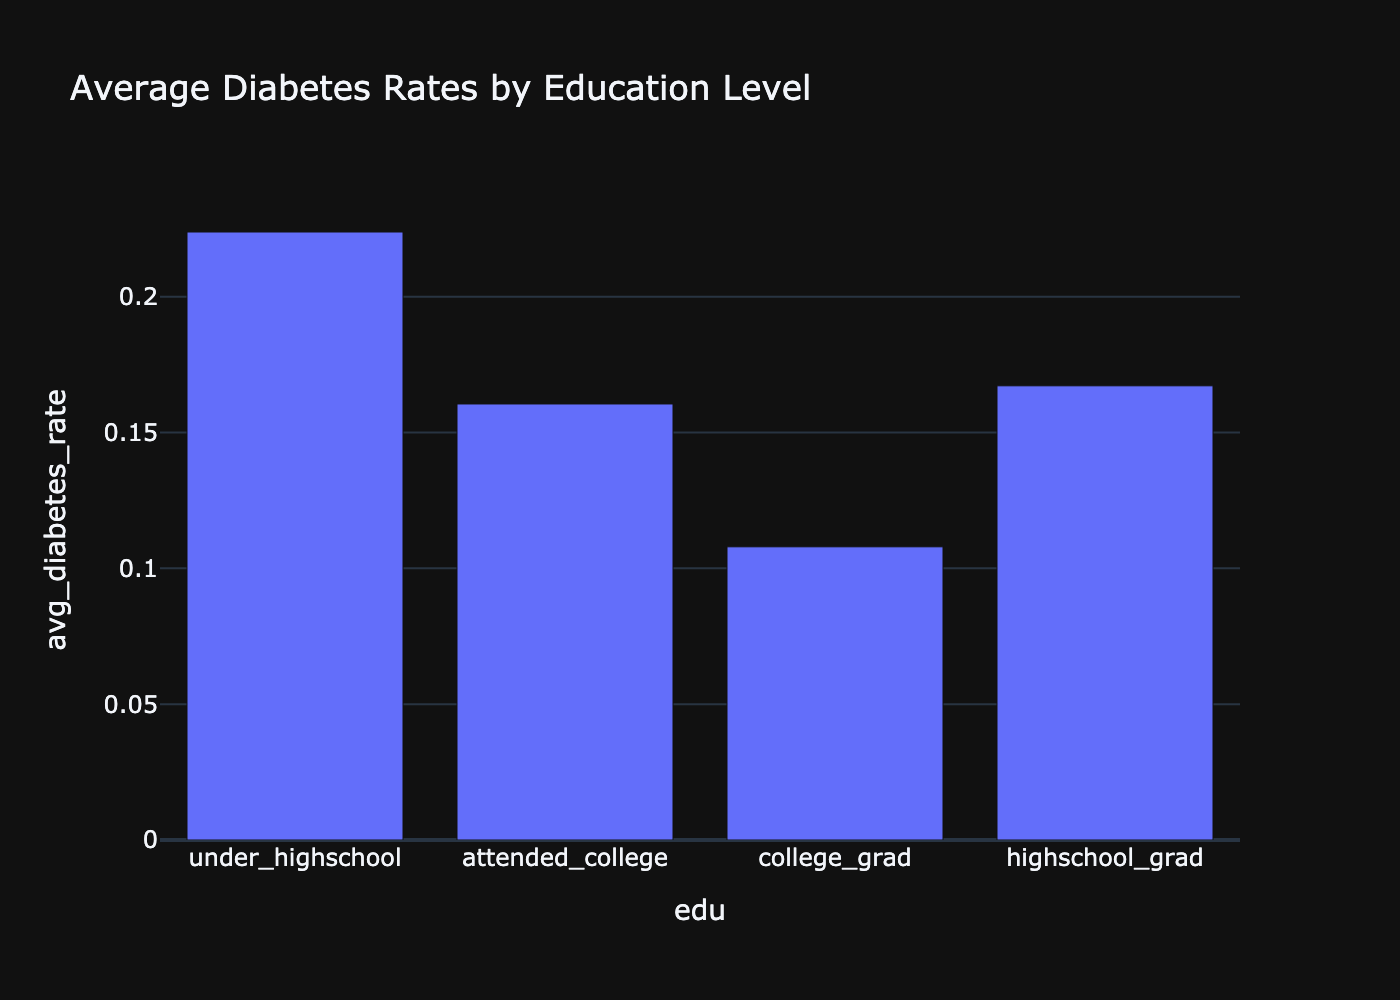

('SELECT edu, AVG(is_diabete) AS avg_diabetes_rate FROM survey GROUP BY edu;',
                 edu  avg_diabetes_rate
 0  under_highschool           0.223825
 1              None           0.139551
 2  attended_college           0.160516
 3      college_grad           0.107932
 4   highschool_grad           0.167199,
 Figure({
     'data': [{'alignmentgroup': 'True',
               'hovertemplate': 'edu=%{x}<br>avg_diabetes_rate=%{y}<extra></extra>',
               'legendgroup': '',
               'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
               'name': '',
               'offsetgroup': '',
               'orientation': 'v',
               'showlegend': False,
               'textposition': 'auto',
               'type': 'bar',
               'x': array(['under_highschool', None, 'attended_college', 'college_grad',
                           'highschool_grad'], dtype=object),
               'xaxis': 'x',
               'y': array([0.22382549, 0.13955071, 0.160

In [47]:
vn.ask("what are the average diabetes rates by education level?")

SQL Prompt: ["You are a DuckDB SQL expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Additional Context \n\nThe following columns are in the survey table in the diabetes_db database:\n\n|    | table_catalog   | table_schema   | table_name   | column_name         | data_type   | COLUMN_COMMENT   |\n|---:|:----------------|:---------------|:-------------|:--------------------|:------------|:-----------------|\n| 37 | diabetes_db     | main           | survey       | is_diabete          | BIGINT      |                  |\n| 38 | diabetes_db     | main           | survey       | high_blood_pressure | DOUBLE      |                  |\n| 39 | diabetes_db     | main           | survey       | high_cholesterol    | DOUBLE      |                  |\n| 40 | diabetes_db     | main           | survey       | bmi                 | DOUBLE      |                  

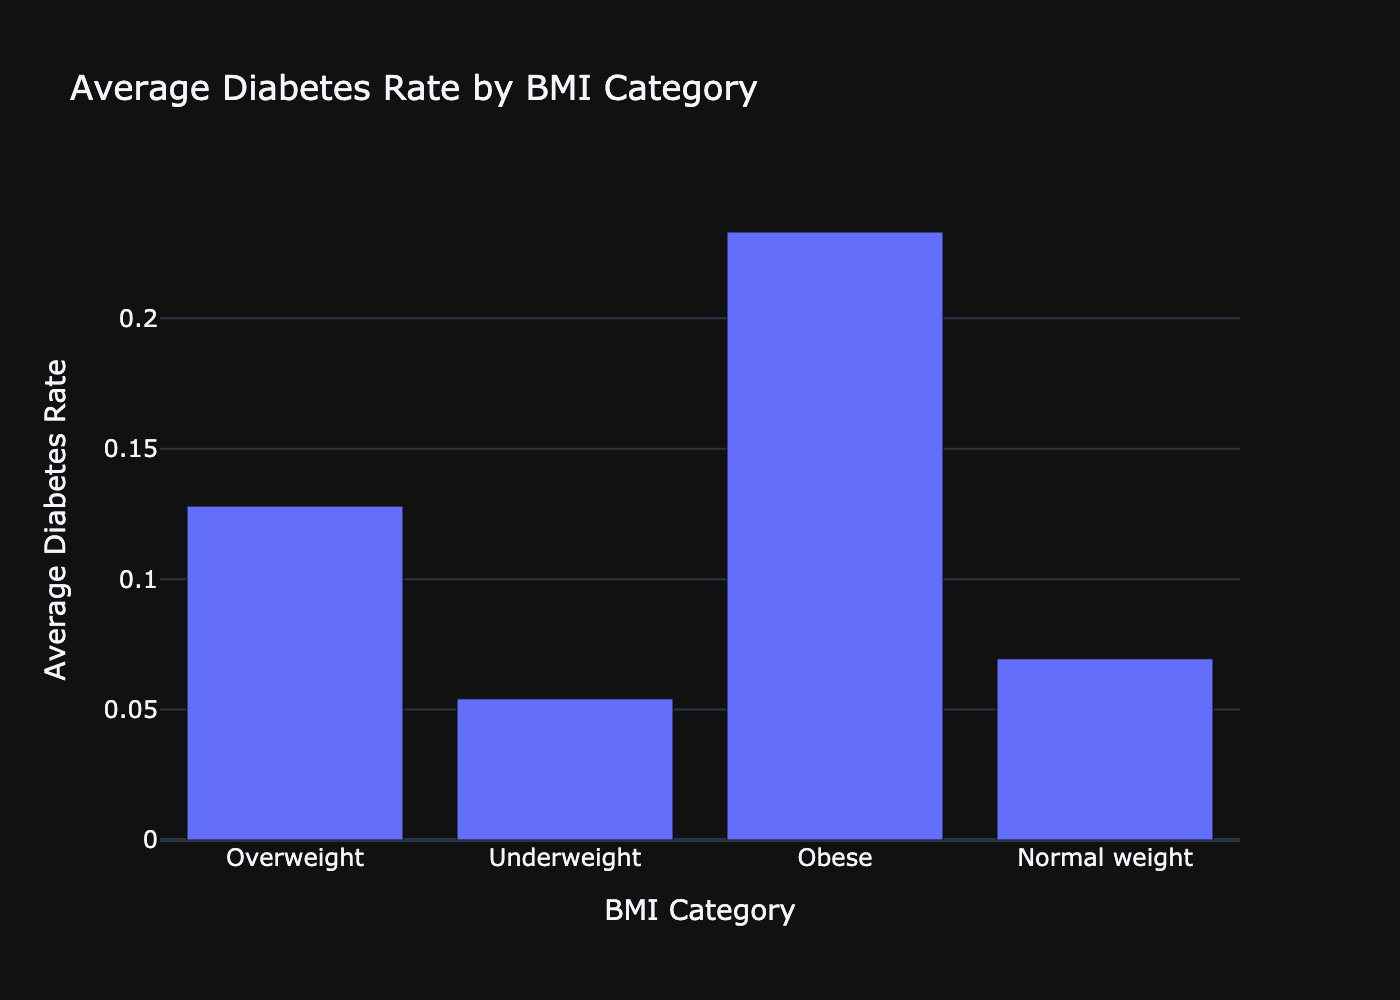

("SELECT\n  CASE\n    WHEN bmi / 100 < 18.5 THEN 'Underweight'\n    WHEN bmi / 100 BETWEEN 18.5 AND 24.9 THEN 'Normal weight'\n    WHEN bmi / 100 BETWEEN 25 AND 29.9 THEN 'Overweight'\n    WHEN bmi / 100 >= 30 THEN 'Obese'\n  END AS bmi_category,\n  AVG(is_diabete) AS avg_diabetes_rate\nFROM survey\nGROUP BY bmi_category;",
     bmi_category  avg_diabetes_rate
 0     Overweight           0.128016
 1    Underweight           0.054116
 2          Obese           0.233097
 3           None           0.134809
 4  Normal weight           0.069459,
 Figure({
     'data': [{'alignmentgroup': 'True',
               'hovertemplate': 'BMI Category=%{x}<br>Average Diabetes Rate=%{y}<extra></extra>',
               'legendgroup': '',
               'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
               'name': '',
               'offsetgroup': '',
               'orientation': 'v',
               'showlegend': False,
               'textposition': 'auto',
               'type': '

In [7]:
vn.ask("How can you describe the relationship between diabetes and bmi? Can you divide bmi into ranges, calculate the averages, and compare them? BMI in the table implies 2 decimal point, which means you may divide bmi column with 100 to calculate the actual bmi.")

-> It seems like Diabetes and Obesity have some relationship. (It is interesting that actual BMI ranges are generated by vanna ai)

SQL Prompt: ["You are a DuckDB SQL expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Additional Context \n\nThe following columns are in the health_exp_tb table in the diabetes_db database:\n\n|    | table_catalog   | table_schema   | table_name    | column_name   | data_type   | COLUMN_COMMENT   |\n|---:|:----------------|:---------------|:--------------|:--------------|:------------|:-----------------|\n|  0 | diabetes_db     | main           | health_exp_tb | Item          | VARCHAR     |                  |\n|  1 | diabetes_db     | main           | health_exp_tb | group_        | VARCHAR     |                  |\n|  2 | diabetes_db     | main           | health_exp_tb | State_Name    | VARCHAR     |                  |\n|  3 | diabetes_db     | main           | health_exp_tb | Y2020         | BIGINT      |                  |\n\nThe following colu

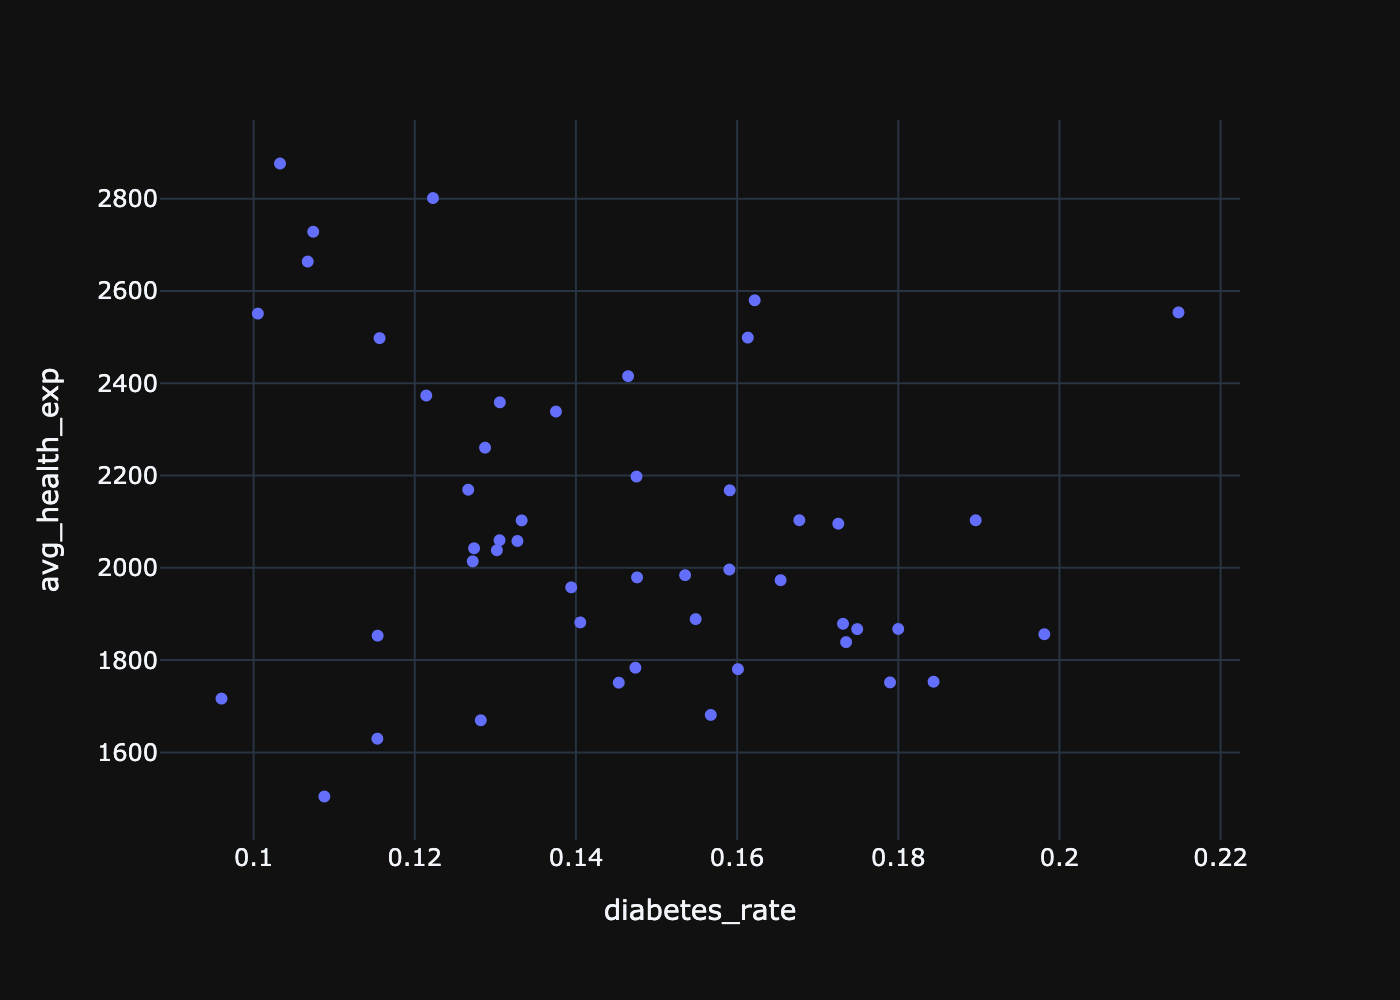

In [50]:
exp = vn.ask("what is the relationship between diabetes rates and healthcare expenditure by state?")

States where personal health care expenditures are higher have lower diabetes rate.

In [5]:
vn.run_sql("select distinct Item from health_exp_tb")

,Item
0,Home Health Care ($)
1,Durable Medical Products ($)
2,Nursing Home Care ($)
3,"Other Health, Residential, and Personal Care ($)"
4,Prescription Drugs and Other Non-durable Medic...
5,Physician & Clinical Services ($)
6,Other Professional Services ($)
7,Personal Health Care ($)
8,Hospital Care ($)
9,Dental Services ($)


SQL Prompt: ["You are a DuckDB SQL expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Additional Context \n\nThe following columns are in the survey table in the diabetes_db database:\n\n|    | table_catalog   | table_schema   | table_name   | column_name         | data_type   | COLUMN_COMMENT   |\n|---:|:----------------|:---------------|:-------------|:--------------------|:------------|:-----------------|\n|  4 | diabetes_db     | main           | survey       | is_diabete          | BIGINT      |                  |\n|  5 | diabetes_db     | main           | survey       | high_blood_pressure | DOUBLE      |                  |\n|  6 | diabetes_db     | main           | survey       | high_cholesterol    | DOUBLE      |                  |\n|  7 | diabetes_db     | main           | survey       | bmi                 | DOUBLE      |                  

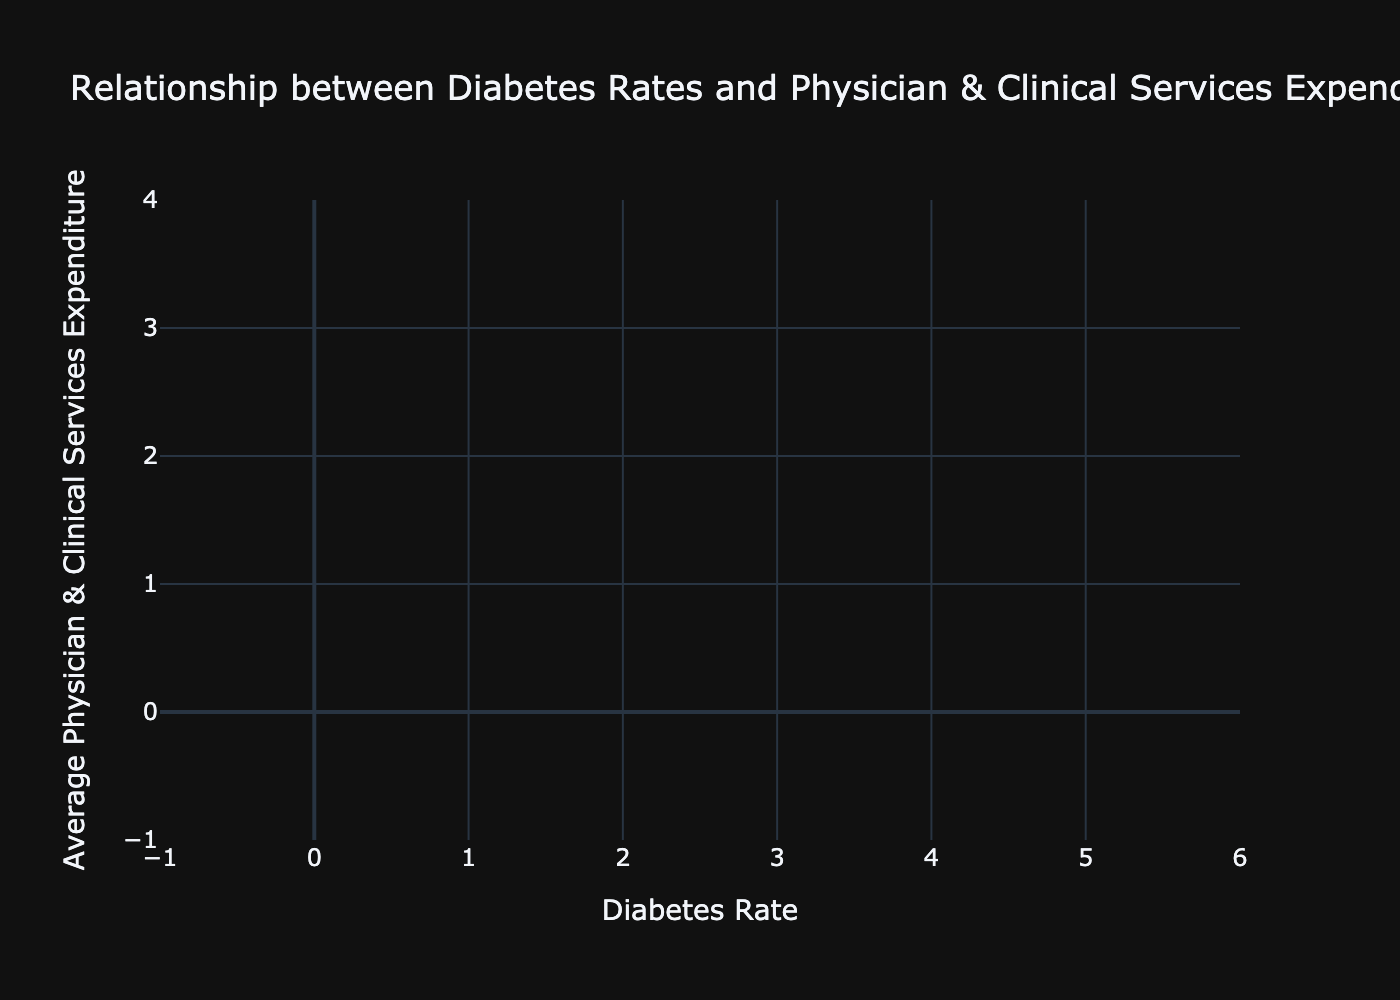

("SELECT\n  s.state,\n  AVG(s.is_diabete) AS diabetes_rate,\n  AVG(h.Y2020) AS avg_health_exp\nFROM survey AS s\nJOIN health_exp_tb AS h\n  ON s.state = h.State_Name\nWHERE\n  h.Item = 'Physician & Clinical Services'\nGROUP BY\n  s.state;",
 Empty DataFrame
 Columns: [state, diabetes_rate, avg_health_exp]
 Index: [],
 Figure({
     'data': [{'customdata': array([], shape=(0, 1), dtype=object),
               'hovertemplate': ('Diabetes Rate=%{x}<br>Average ' ... '{customdata[0]}<extra></extra>'),
               'legendgroup': '',
               'marker': {'color': '#636efa', 'symbol': 'circle'},
               'mode': 'markers',
               'name': '',
               'orientation': 'v',
               'showlegend': False,
               'type': 'scatter',
               'x': array([], dtype=float64),
               'xaxis': 'x',
               'y': array([], dtype=float64),
               'yaxis': 'y'},
              {'hovertemplate': '<extra></extra>',
               'legendgroup':

In [6]:
vn.ask("what is the relationship between diabetes rates and Physician & Clinical Services expenditure by state?")

It does not correctly identify element names, even though I trained it on the elements in each column

SQL Prompt: ["You are a DuckDB SQL expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Additional Context \n\nThe following columns are in the survey table in the diabetes_db database:\n\n|    | table_catalog   | table_schema   | table_name   | column_name         | data_type   | COLUMN_COMMENT   |\n|---:|:----------------|:---------------|:-------------|:--------------------|:------------|:-----------------|\n|  4 | diabetes_db     | main           | survey       | is_diabete          | BIGINT      |                  |\n|  5 | diabetes_db     | main           | survey       | high_blood_pressure | DOUBLE      |                  |\n|  6 | diabetes_db     | main           | survey       | high_cholesterol    | DOUBLE      |                  |\n|  7 | diabetes_db     | main           | survey       | bmi                 | DOUBLE      |                  

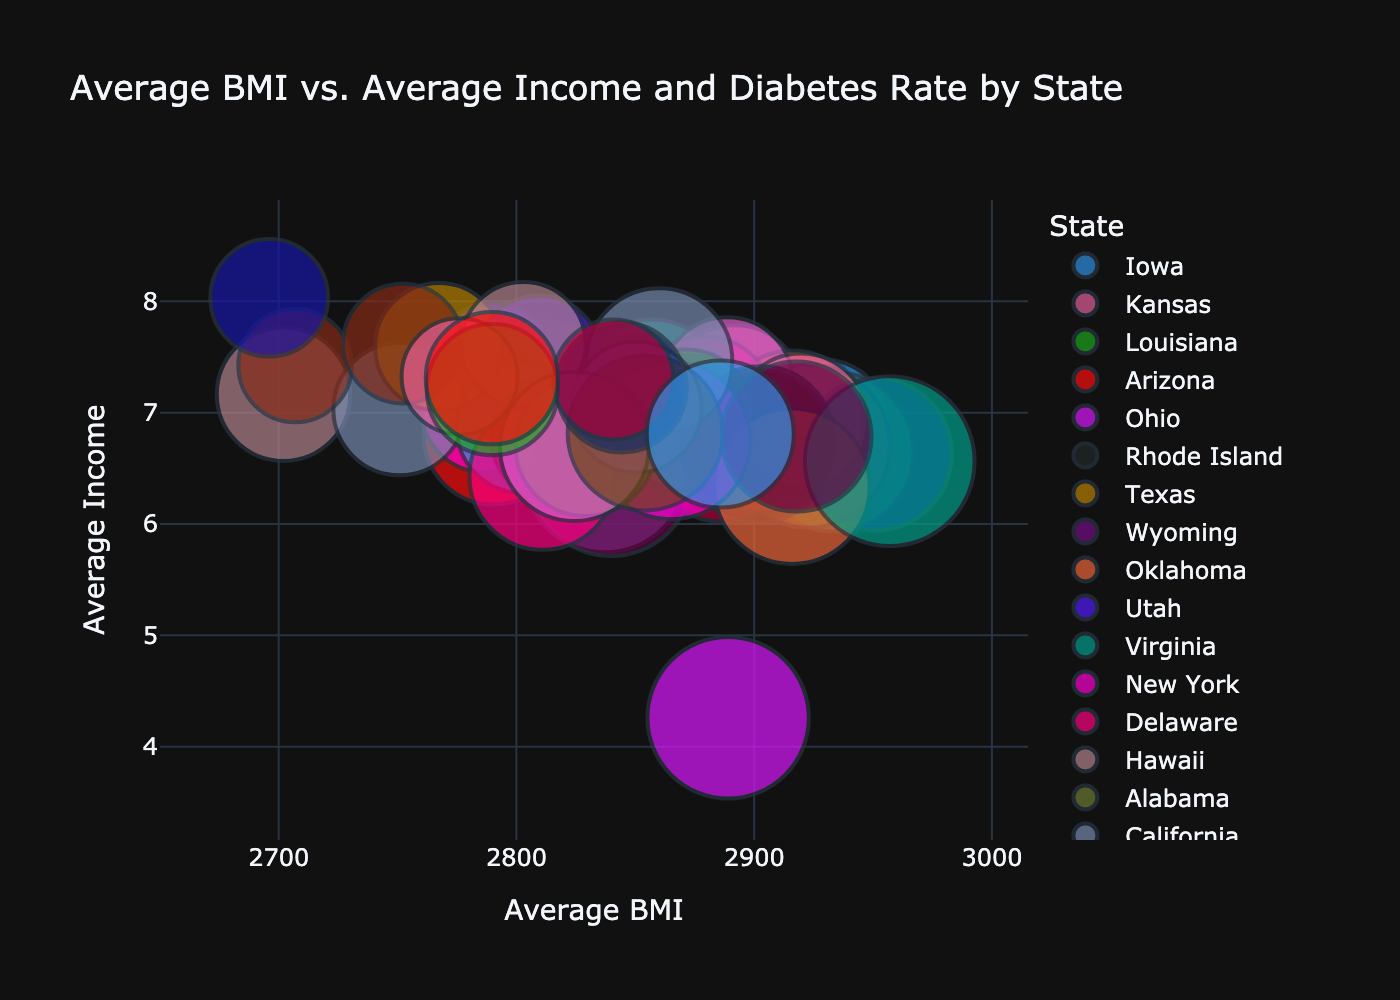

In [21]:
t = vn.ask("""Create a bubble chart representing data for states. 
           The x-axis should display the average BMI, the y-axis should show the average income level, 
           and the size of each bubble should correspond to the diabetes rate in each state  with a wide size variation to clearly differentiate 
           between low and high diabetes rates. Use a diverse color palette to assign unique colors to all states, 
           ensuring no duplication even if there are more than 51 states. 
           Include gridlines, appropriate axis labels, and a legend to enhance clarity and usability.""")